In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numba import njit
from matplotlib.animation import FuncAnimation

# Jos Stam Paper - http://graphics.cs.cmu.edu/nsp/course/15-464/Fall09/papers/StamFluidforGames.pdf
# Gonkee Video - https://www.youtube.com/watch?v=qsYE1wMEMPA
# Numba - https://www.youtube.com/watch?v=qsYE1wMEMPA
# Coding Train - https://www.youtube.com/watch?v=alhpH6ECFvQ&t=1165s

In [41]:
# full - reflect
# lr - copy top and bottom, reflect others
# ud - copy left and right, reflect others

@njit(fastmath=True)
def set_bnd(N, b, X):
    for i in range(1, N+1):
        X[0][i] = -X[1][i] if b == "ud" else X[1][i]
        X[N+1][i] = -X[N][i] if b == "ud" else X[N][i]
        
        X[i][0] = -X[i][1] if b == "lr" else X[i][1]
        X[i][N+1] = -X[i][N] if b == "lr" else X[i][N]
    
    #do corners - average of 2 around
    X[0][0] = (X[1][0] + X[0][1]) * 0.5
    X[0][N+1] = (X[1][N+1] + X[0][N]) * 0.5
    X[N+1][0] = (X[N][0] + X[N+1][1]) * 0.5
    X[N+1][N+1] = (X[N][N+1] + X[N+1][N]) * 0.5
    
@njit(fastmath=True)
def addSource(i, j, X, x):
    X[i][j] += dt * x
    
# Diffuse backwards in time: x0[IX(i,j)] = x[IX(i,j)] - a*(x[IX(i-1,j)]+x[IX(i+1,j)]+x[IX(i,j-1)]+x[IX(i,j+1)] -4*x[IX(i,j)]);
# ==> ( x0[IX(i,j)] + a*(x[IX(i-1,j)]+x[IX(i+1,j)]+x[IX(i,j-1)]+x[IX(i,j+1)]) ) / ( 1 + 4*a )

@njit(fastmath=True)
def diffuse(N, X, X0, coef, b = "full", n_iter = 20):
        # Gauss-Seidel: observation - very few non-zero values in matrix & strictly diagonally dominant
        # start with incorrect values, solve by iteratively calculating assuming incorrect values are correct, then setting result as the new incorrect value
        a = dt * coef * N * N
        
        for k in range(n_iter):
            for i in range(1, N+1):
                for j in range(1, N+1):
                    X[i][j] = (X0[i][j] + a*(X[i-1][j] + X[i][j-1] + X[i][j+1] + X[i+1][j]))/(1+4*a)
                    
            # what to do when collision with boundary
            set_bnd(N, b, X)

            
# linear interpolation, loc x in length 1, a to b
@njit(fastmath=True)
def lerp(a, b, x):
    slope = b - a
    return a + slope * x
    
# advect backwards (start from center and go back), using next velocity to linear interpolate, to find density contributions
# Note: may need coefficient for multiplier ==> mult changes with dt?
@njit(fastmath=True)
def advect(N, X, X0, u, v, b = "full"):
    for i in range(1, N+1):
        for j in range(1, N+1):
#             print("BEFORE: ", X[i][j])
            y = i - dt * N * v[i][j]
            x = j - dt * N * u[i][j]
            
#             print(i, j, x, y)
            
            if (x < 0.5):
                x = 0.5
                
            if (x > N + 0.5):
                x = N + 0.5;
                
            if (y < 0.5):
                y = 0.5
                
            if (y > N + 0.5):
                y = N + 0.5;
            
            frac_y = y - math.floor(y)
            frac_x = x - math.floor(x)

            y = math.floor(y)
            x = math.floor(x)
            
            #first interpolate looking through the x dimension
            x0 = lerp(X0[y][x], X0[y][x+1], frac_x)
            x1 = lerp(X0[y+1][x], X0[y+1][x+1], frac_x)
            
            #then interpolate looking through x dimension
            res = lerp(x0, x1, frac_y)
            X[i][j] += res
#             print("AFTER", X[i][j])

    set_bnd(N, b, X)
    
# By helmholtz's theorem, every velocity field is the addition of a curl-free and divergence-free vector field. In this function, we compute the divergence-free field by computing curl-free and subtracting it from original
@njit(fastmath=True)
def project(N, u, v, p, div, n_iter=20):
    for i in range(1, N+1):
        for j in range(1, N+1):
            div[i][j] = -0.5 * (u[i][j+1] - u[i][j-1] + v[i+1][j] - v[i-1][j]) / N
            p[i][j] = 0
    
    set_bnd(N, "full", div)
    set_bnd(N, "full", p)
    
    for k in range(n_iter):
        for i in range(1, N+1):
            for j in range(1, N+1):
                p[i][j] = (div[i][j] + p[i-1][j] + p[i+1][j] + p[i][j-1] + p[i][j+1]) / 4
        set_bnd(N, "full", p)
    
    for i in range(1, N+1):
        for j in range(1, N+1):
            u[i][j] -= 0.5 * (p[i][j+1] - p[i][j-1]) * N
            v[i][j] -= 0.5 * (p[i+1][j] - p[i-1][j]) * N
            
    set_bnd(N, "lr", u)
    set_bnd(N, "ud", v)
    
'''
To calculate the curl-free field of a given vector field using Poisson equations, you can use the following steps:

Define your vector field as a function of the coordinates of the grid points. Let's call this vector field V(x,y,z), where x,y,z are the coordinates of a given grid point.

Calculate the curl of the vector field using the curl operator: curl(V) = (dVz/dy - dVy/dz, dVx/dz - dVz/dx, dVy/dx - dVx/dy). This will give you a new vector field that represents the direction and magnitude of the curl of the original vector field at each grid point.

Use the Poisson equation to find a scalar potential function φ(x,y,z) that satisfies the equation ∇²φ = -div(curl(V)), where ∇² is the Laplace operator and div is the divergence operator. This scalar potential function will represent the curl-free component of the original vector field.

Calculate the gradient of the scalar potential function using the gradient operator: grad(φ) = (∂φ/∂x, ∂φ/∂y, ∂φ/∂z). This will give you a new vector field that represents the direction and magnitude of the curl-free component of the original vector field at each grid point.

Subtract the curl-free vector field from the original vector field to get the remaining curl component: V_curl = V - grad(φ).

Following these steps should allow you to calculate the curl-free component of your vector field using Poisson equations. Note that the calculation of the scalar potential function φ can be done using various numerical methods such as finite difference, finite element, or spectral methods, depending on the specifics of your problem.
'''

"\nTo calculate the curl-free field of a given vector field using Poisson equations, you can use the following steps:\n\nDefine your vector field as a function of the coordinates of the grid points. Let's call this vector field V(x,y,z), where x,y,z are the coordinates of a given grid point.\n\nCalculate the curl of the vector field using the curl operator: curl(V) = (dVz/dy - dVy/dz, dVx/dz - dVz/dx, dVy/dx - dVx/dy). This will give you a new vector field that represents the direction and magnitude of the curl of the original vector field at each grid point.\n\nUse the Poisson equation to find a scalar potential function φ(x,y,z) that satisfies the equation ∇²φ = -div(curl(V)), where ∇² is the Laplace operator and div is the divergence operator. This scalar potential function will represent the curl-free component of the original vector field.\n\nCalculate the gradient of the scalar potential function using the gradient operator: grad(φ) = (∂φ/∂x, ∂φ/∂y, ∂φ/∂z). This will give you a n

In [42]:
import random

theta = random.random() * math.pi * 2
def rotate(speed = 2 * math.pi / 5, prob = 0.15):
    global theta
    # expected to change direction in 1/prob seconds
    prob *= dt

#     if random.random() < prob:
#         speed *= -1
#         print("Switched")
        
    theta += speed * dt
    
@njit(fastmath=True)
def vel_step(N, u, v, u0, v0):    
    diffuse (N, u, u0, visc, b="lr")
    diffuse (N, v, v0, visc, b="ud")
#     diffuse (u0, u, visc, b="lr")
#     diffuse (v0, v, visc, b="ud")
    
    # project first because advect works better with a divergence-free v-field
    #BELOW MAY BE WRONG -- Swapped 0 and cur?
    project(N, u0, v0, u, v)
        
    advect (N, u, u0, u0, v0, b="lr")
    advect (N, v, v0, u0, v0, b="ud")
    
    project(N, u, v, u0, v0)
#     addSource (i_u, j_u, u, radius)
    
@njit(fastmath=True)
def dens_step(N, dens, dens0, u, v):    
    # below might be wrong?
    diffuse (N, dens, dens0, diff)
    advect (N, dens, dens0, u, v)

# def fade():
#     global dens
#     dens *= 0.98
#     for i in range(sz):
#         for j in range(sz):
#             if dens[i][j] > 0:
# #                 dens[i][j] *= 0.95
#                 dens[i][j] -= 0.01

In [47]:
%%time

from tqdm import tqdm

animation_frames = []

N_time_steps = 5
# current_time = 0

N = 40
# 0, N+1 are reserved for boundary cells
sz = N + 2
dt = 0.1

diff = 0.1
visc = 0.1

dens0 = np.zeros((sz, sz))
# v is y direction velocity ~ j
v0 = np.zeros((sz, sz))
# u is x direction velocity ~ i
u0 = np.zeros((sz, sz))

for i in tqdm(range(N_time_steps)):
    dens = np.zeros((sz, sz))
    u = np.zeros((sz, sz))
    v = np.zeros((sz, sz))

    addSource (sz//2, sz//2, u0, 200)
    vel_step (N, u, v, u0, v0)
#     v0 = v
#     u0 = u
#     if i < 5:
        
#     plt.quiver(u, v, color='b', units='xy', scale = max(np.max(u), np.max(v)))
#     plt.show()

#     print("SATRTING DENSITY STESP")
    addSource(sz//2, sz//2, dens0, 1)
    dens_step(N, dens, dens0, u, v)

    animation_frames.append(dens)
    print(u)
#     print(np.max(u))
    print(v)
#     fade()
    
    dens0 = dens
    v0 = v
    u0 = u

100%|██████████| 5/5 [00:00<00:00, 207.70it/s]

[[ 0.00000000e+00  1.81885179e-11  1.54903362e-10 ...  1.49171719e-06
   5.18750890e-07  0.00000000e+00]
 [-1.81885179e-11  1.81885179e-11  1.54903362e-10 ...  1.49171719e-06
   5.18750890e-07 -5.18750890e-07]
 [-1.40753757e-10  1.40753757e-10  9.49572395e-10 ...  2.55294206e-06
   8.82244422e-07 -8.82244422e-07]
 ...
 [-3.17203394e-06  3.17203394e-06  9.19815204e-06 ...  5.22636579e-05
   1.80091194e-05 -1.80091194e-05]
 [-2.55541616e-06  2.55541616e-06  7.40866431e-06 ...  4.44912640e-05
   1.53565855e-05 -1.53565855e-05]
 [ 0.00000000e+00  2.55541616e-06  7.40866431e-06 ...  4.44912640e-05
   1.53565855e-05  0.00000000e+00]]
[[ 0.00000000e+00 -1.91104441e-11 -1.41675683e-10 ...  2.12440053e-06
   1.76090704e-06  0.00000000e+00]
 [ 1.91104441e-11  1.91104441e-11  1.41675683e-10 ... -2.12440053e-06
  -1.76090704e-06 -1.76090704e-06]
 [ 1.69743428e-10  1.69743428e-10  9.95641828e-10 ... -6.55732618e-06
  -5.42952137e-06 -5.42952137e-06]
 ...
 [-3.27242400e-06 -3.27242400e-06 -5.1169234

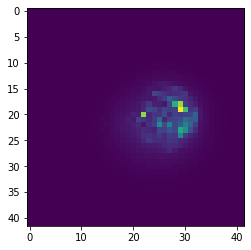

In [48]:
%matplotlib inline
import time
from IPython.display import clear_output

for i in range(N_time_steps):
    # Not by
    clear_output(wait=True)
#     plt.clf()
    
    fig, ax = plt.subplots()
    ax.imshow(animation_frames[i])
    plt.show()
#     time.sleep(dt)

# plt.imshow(animation_frames[99])
plt.show()
# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

<ipython-input-196-dd6a1bb52703>:16: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, updatefig)


IndexError: list index out of range

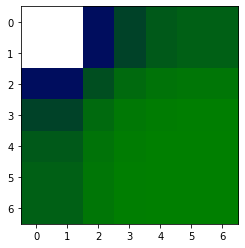

In [196]:
# execute this cell
%matplotlib inline
# %matplotlib notebook

fig, ax = plt.subplots()
im = ax.imshow(animation_frames[0], animated=True, cmap='ocean')

def updatefig(*args):
    im.set_array(animation_frames[args[0]])
    return im,

# ani = animation.FuncAnimation(fig, update, interval=50,
#                               save_count=50)
# plt.show()

ani = FuncAnimation(fig, updatefig)

ani.save('bob.mp4', extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])

plt.show()